In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import itertools
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve 
import numpy as np
import pandas as pd

import string
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
import tqdm

# 1. Preprocessing

In [2]:
# We define utility functions for text processing.

def removePunctuation(text):
    """
    Remove punctuation symbols and convert text to lowercase
    """
    return text.lower().translate(str.maketrans('', '', string.punctuation))

def removeStopWords(text):
    """
    Filter words that are not found in stop words
    """
    return " ".join([word for word in text.split() if word not in stopwords.words("english")])

def buildDictionary(texts):
    """
    Build the dictionary of words where key is the word and value is the index.
    """
    hashmap = {}
    for text in texts:
        for word in text.split():
            hashmap[word] = hashmap.get(word, 0) + 1
    return {w:i+1 for i, w in enumerate(list(hashmap.keys()))}

def calculateMaxSeqLen(texts):
    """
    Calculates the maximum sequence length found in the corpus
    """
    max_len = float('-inf')
    for text in texts:
        if len(text.split()) > max_len:
            max_len = len(text.split())
            
    return max_len

In [3]:
# Load the *.csv* file and filter the features that are useful for the problem:
data = pd.read_csv("C:/datasets/nlp-getting-started/train.csv")

In [4]:
data = data[["text","target"]]

In [5]:
data

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


In [6]:
data["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [7]:
# Text preprocessing. Remove punctuation symbols and stop words:
data["text"] = data["text"].apply(lambda x: removePunctuation(x))
data["text"] = data["text"].apply(lambda x: removeStopWords(x))

In [8]:
dictionary = buildDictionary(data["text"])
max_seq_len = calculateMaxSeqLen(data["text"])

print(f"Number of words in dictionary: {len(dictionary)}")
print(f"Maximum sequence lenght: {max_seq_len}")

Number of words in dictionary: 22564
Maximum sequence lenght: 25


In [9]:
data["target"].value_counts() / len(data)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [10]:
data

,text,target
0,deeds reason earthquake may allah forgive us,1
1,forest fire near la ronge sask canada,1
2,residents asked shelter place notified officer...,1
3,13000 people receive wildfires evacuation orde...,1
4,got sent photo ruby alaska smoke wildfires pou...,1
...,...,...
7608,two giant cranes holding bridge collapse nearb...,1
7609,ariaahrary thetawniest control wild fires cali...,1
7610,m194 0104 utc5km volcano hawaii httptcozdtoyd8ebj,1
7611,police investigating ebike collided car little...,1


In [11]:
# Split data into training and testing
x_train, x_valid, y_train, y_valid = train_test_split(data["text"], data["target"], test_size=0.3, stratify=data["target"])

# 2. Data loaders

In [12]:
y_valid.value_counts()

0    1303
1     981
Name: target, dtype: int64

In [13]:
y_train.value_counts()

0    3039
1    2290
Name: target, dtype: int64

In [14]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
DROPOUT = 0.4
INPUT_SIZE = len(dictionary) + 1

In [15]:
class DataHandler(Dataset):
    """
    Iterator generator for data loader construction
    """
    
    @staticmethod
    def tokenizer(X, max_seq_len, dicitionary):
        """
        Given a sequence of words, tokenize each word with 
        use of `dictionary` and apply padding considering `max_seq_len`
        """
        sequences = []
        for x in X:
            sequence = [0] * max_seq_len
            for idx, word in enumerate(x.split()):
                sequence[idx] = dictionary[word]
            sequences.append(sequence)
            
        return np.array(sequences)
    
    def __init__(self, x, y, max_seq_len, dictionary):
        self.x = self.tokenizer(x, max_seq_len, dictionary)
        self.y = y.to_numpy()
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [16]:
# Initialize iterator objects for the data loader
train = DataHandler(x_train, y_train, max_seq_len, dictionary)
valid = DataHandler(x_valid, y_valid, max_seq_len, dictionary)

In [17]:
# Initialize data loaders
loader_training = DataLoader(train, batch_size=BATCH_SIZE, shuffle=False)
loader_valid = DataLoader(valid, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
txt1 = iter(loader_valid)

In [19]:
x, y = next(txt1)

In [20]:
dictionary

{'deeds': 1,
 'reason': 2,
 'earthquake': 3,
 'may': 4,
 'allah': 5,
 'forgive': 6,
 'us': 7,
 'forest': 8,
 'fire': 9,
 'near': 10,
 'la': 11,
 'ronge': 12,
 'sask': 13,
 'canada': 14,
 'residents': 15,
 'asked': 16,
 'shelter': 17,
 'place': 18,
 'notified': 19,
 'officers': 20,
 'evacuation': 21,
 'orders': 22,
 'expected': 23,
 '13000': 24,
 'people': 25,
 'receive': 26,
 'wildfires': 27,
 'california': 28,
 'got': 29,
 'sent': 30,
 'photo': 31,
 'ruby': 32,
 'alaska': 33,
 'smoke': 34,
 'pours': 35,
 'school': 36,
 'rockyfire': 37,
 'update': 38,
 'hwy': 39,
 '20': 40,
 'closed': 41,
 'directions': 42,
 'due': 43,
 'lake': 44,
 'county': 45,
 'cafire': 46,
 'flood': 47,
 'disaster': 48,
 'heavy': 49,
 'rain': 50,
 'causes': 51,
 'flash': 52,
 'flooding': 53,
 'streets': 54,
 'manitou': 55,
 'colorado': 56,
 'springs': 57,
 'areas': 58,
 'im': 59,
 'top': 60,
 'hill': 61,
 'see': 62,
 'woods': 63,
 'theres': 64,
 'emergency': 65,
 'happening': 66,
 'building': 67,
 'across': 68,
 '

In [21]:
x_valid.reset_index()["text"].loc[0].split() 

['brodyfrieling', 'hannabrooksie', 'photo', 'bombed']

In [22]:
for word in x_valid.reset_index()["text"].loc[0].split() :
    print(dictionary[word])

4965
4966
31
4888


In [23]:
x[0]

tensor([4965, 4966,   31, 4888,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0], dtype=torch.int32)

In [24]:
y_valid.reset_index()["target"].loc[0]

0

In [25]:
y[0].item()

0

# 3. Model

In [26]:
x.shape, len(y)

(torch.Size([64, 25]), 64)

In [31]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
LSTM_LAYERS = 2

class TextClassifier(nn.ModuleList):
    """
    LSTM Network definition
    """
    def __init__(self):
        super(TextClassifier, self).__init__()

        self.batch_size = BATCH_SIZE
        self.embedding_dim = EMBEDDING_DIM
        self.hidden_dim = HIDDEN_DIM
        self.LSTM_layers = LSTM_LAYERS
        self.input_size = INPUT_SIZE

        self.dropout = nn.Dropout(DROPOUT)
        self.embedding = nn.Embedding(num_embeddings=self.input_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.hidden_dim, 
                            num_layers=self.LSTM_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(in_features=self.hidden_dim*4, out_features=256)
        self.fc2 = nn.Linear(256, 1)
    

    def forward(self, x):

#         h = torch.zeros((self.LSTM_layers, x.size(0), self.hidden_dim)).to(device)
#         c = torch.zeros((self.LSTM_layers, x.size(0), self.hidden_dim)).to(device)
        
#         torch.nn.init.xavier_normal_(h)
#         torch.nn.init.xavier_normal_(c)
        
        embedded = self.embedding(x)
        out, (hidden, cell) = self.lstm(embedded)
        out = self.dropout(out)
        concat_hidden = torch.cat((hidden[0], hidden[1]), dim=1)
        concat_cell = torch.cat((cell[0], cell[1]), dim=1)
        all_states = torch.cat((concat_hidden, concat_cell), dim=1)
        out = torch.relu_(self.fc1(all_states))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))
        return out.squeeze()

# Identify device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model initialization
model = TextClassifier().to(device)
print(model)

TextClassifier(
  (dropout): Dropout(p=0.4, inplace=False)
  (embedding): Embedding(22565, 100, padding_idx=0)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)


In [32]:
x.shape

torch.Size([64, 25])

In [33]:
y.shape

torch.Size([64])

In [34]:
model(x.cuda()).shape

torch.Size([64])

In [35]:
# Optimizer initialization
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()

In [36]:
def calculate_accuracy_with_selected_threshold(grand_truth, predictions):
    """
    Accuracy calcuation: (tp + tn) / N
    """
    true_positives, true_negatives = 0, 0
    fpr, tpr, thr = roc_curve(grand_truth, predictions)
    roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thr':thr});
    roc['random'] = roc['fpr'].copy()
    roc['diff'] = roc['tpr'] - roc['fpr']
    roc = roc.sort_values('diff', ascending=False).reset_index().drop('index', axis=1)
    
    for true, pred in zip(grand_truth, predictions):
        if (pred > roc.loc[0,'thr']) and (true == 1):
            true_positives += 1
        elif (pred < roc.loc[0,'thr']) and (true == 0):
            true_negatives += 1
    return (true_positives+true_negatives) / len(grand_truth)

def calculate_accuray_with_point_five(grand_truth, predictions):
    """
    Accuracy calcuation: (tp + tn) / N
    """
    true_positives, true_negatives = 0, 0    
    for true, pred in zip(grand_truth, predictions):
        if (pred > 0.5) and (true == 1):
            true_positives += 1
        elif (pred < 0.5) and (true == 0):
            true_negatives += 1
    return (true_positives+true_negatives) / len(grand_truth)

In [37]:
# Training
EPOCHS = 50
valid_accuracy_min = 0
for epoch in range(EPOCHS):
    model.train()
    train_predictions = []
    for x_batch, y_batch in tqdm.tqdm(loader_training, desc=f"training epoch {epoch+1}"):
        
        x = x_batch.type(torch.LongTensor).to(device)
        y = y_batch.type(torch.FloatTensor).to(device)
        
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Save predictions for metrics calculation
        train_predictions += list(y_pred.squeeze().cpu().detach().numpy())
    
    # Evaluation
    with torch.no_grad():
        model.eval()
        valid_predictions = []
        for x_batch, y_batch in tqdm.tqdm(loader_valid, desc=f"validation epoch {epoch+1}"):
            x = x_batch.type(torch.LongTensor).to(device)
            y = y_batch.type(torch.FloatTensor).to(device)
            
            y_pred = model(x)
            # Save predictions for metrics calculation
            valid_predictions += list(y_pred.squeeze().cpu().detach().numpy())

    train_accuracy = calculate_accuracy_with_selected_threshold(y_train, train_predictions)
    valid_accuracy = calculate_accuracy_with_selected_threshold(y_valid, valid_predictions)
    print(f"epoch: {epoch+1}, loss: {loss.item():.5f}, train: {train_accuracy:.5f}, valid: {valid_accuracy:.5f}")
    if valid_accuracy >= valid_accuracy_min:
        print('Valid metrics improved ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_accuracy_min,valid_accuracy))
        # change the name, for saving multiple files
        torch.save(model.state_dict(), 'text_clf.pt')
        valid_accuracy_min = valid_accuracy
        print("=========================================")

validation epoch 1: 100%|█████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 286.88it/s]


epoch: 1, loss: 0.63132, train: 0.59805, valid: 0.68739
Valid metrics improved (0.000000 --> 0.687391).  Saving model ...


validation epoch 2: 100%|█████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 295.05it/s]


epoch: 2, loss: 0.36294, train: 0.74967, valid: 0.73993
Valid metrics improved (0.687391 --> 0.739930).  Saving model ...


validation epoch 3: 100%|█████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 290.22it/s]


epoch: 3, loss: 0.17079, train: 0.85138, valid: 0.75131
Valid metrics improved (0.739930 --> 0.751313).  Saving model ...


validation epoch 4: 100%|█████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 289.01it/s]


epoch: 4, loss: 0.06049, train: 0.91687, valid: 0.76576
Valid metrics improved (0.751313 --> 0.765762).  Saving model ...


validation epoch 5: 100%|█████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 297.47it/s]


epoch: 5, loss: 0.10672, train: 0.95534, valid: 0.75394


validation epoch 6: 100%|█████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 291.49it/s]


epoch: 6, loss: 0.00666, train: 0.96247, valid: 0.75744


validation epoch 7: 100%|█████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 289.01it/s]


epoch: 7, loss: 0.01074, train: 0.96998, valid: 0.74956


validation epoch 8: 100%|█████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 286.72it/s]


epoch: 8, loss: 0.00895, train: 0.98236, valid: 0.74606


validation epoch 9: 100%|█████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 290.21it/s]


epoch: 9, loss: 0.01418, train: 0.98461, valid: 0.74781


validation epoch 10: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 291.49it/s]


epoch: 10, loss: 0.03321, train: 0.98837, valid: 0.74343


validation epoch 11: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 292.66it/s]


epoch: 11, loss: 0.01759, train: 0.98724, valid: 0.74825


validation epoch 12: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 292.67it/s]


epoch: 12, loss: 0.01708, train: 0.98874, valid: 0.75088


validation epoch 13: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 290.17it/s]


epoch: 13, loss: 0.01418, train: 0.98987, valid: 0.73949


validation epoch 14: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 289.01it/s]


epoch: 14, loss: 0.00826, train: 0.98949, valid: 0.73862


validation epoch 15: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 292.51it/s]


epoch: 15, loss: 0.02936, train: 0.99231, valid: 0.74387


validation epoch 16: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 292.66it/s]


epoch: 16, loss: 0.00111, train: 0.99400, valid: 0.74343


validation epoch 17: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 289.20it/s]


epoch: 17, loss: 0.00237, train: 0.99418, valid: 0.74037


validation epoch 18: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 288.02it/s]


epoch: 18, loss: 0.00004, train: 0.99362, valid: 0.74081


validation epoch 19: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 289.04it/s]


epoch: 19, loss: 0.00030, train: 0.99418, valid: 0.73730


validation epoch 20: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 272.74it/s]


epoch: 20, loss: 0.00004, train: 0.99475, valid: 0.73774


validation epoch 21: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 286.88it/s]


epoch: 21, loss: 0.00015, train: 0.99531, valid: 0.74606


validation epoch 22: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 293.69it/s]


epoch: 22, loss: 0.00021, train: 0.99531, valid: 0.73687


validation epoch 23: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 293.80it/s]


epoch: 23, loss: 0.00014, train: 0.99568, valid: 0.73292


validation epoch 24: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 291.15it/s]


epoch: 24, loss: 0.00008, train: 0.99587, valid: 0.73336


validation epoch 25: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 289.08it/s]


epoch: 25, loss: 0.00008, train: 0.99550, valid: 0.74825


validation epoch 26: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 286.80it/s]


epoch: 26, loss: 0.00003, train: 0.99625, valid: 0.74781


validation epoch 27: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 287.04it/s]


epoch: 27, loss: 0.00001, train: 0.99512, valid: 0.74475


validation epoch 28: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 289.10it/s]


epoch: 28, loss: 0.01122, train: 0.99437, valid: 0.74869


validation epoch 29: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 279.04it/s]


epoch: 29, loss: 0.00325, train: 0.98161, valid: 0.73862


validation epoch 30: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 285.69it/s]


epoch: 30, loss: 0.03128, train: 0.98105, valid: 0.72986


validation epoch 31: 100%|████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 284.49it/s]


epoch: 31, loss: 0.00043, train: 0.99174, valid: 0.74650


training epoch 32:  57%|███████████████████████████████████▍                          | 48/84 [00:00<00:00, 129.92it/s]


KeyboardInterrupt: 

In [38]:
model.load_state_dict(torch.load('text_clf.pt'))

<All keys matched successfully>

In [39]:
with torch.no_grad():
    model.eval()
    valid_predictions = []
    for x_batch, y_batch in loader_valid:
        x = x_batch.type(torch.LongTensor).to(device)
        y = y_batch.type(torch.FloatTensor).to(device)

        y_pred = model(x)
        # Save predictions for metrics calculation
        valid_predictions += list(y_pred.squeeze().cpu().detach().numpy())
        
    valid_accuracy = calculate_accuracy_with_selected_threshold(y_valid, valid_predictions)
    print(f"valid accuracy: {valid_accuracy:.5f}")

valid accuracy: 0.76576


<AxesSubplot:xlabel='fpr'>

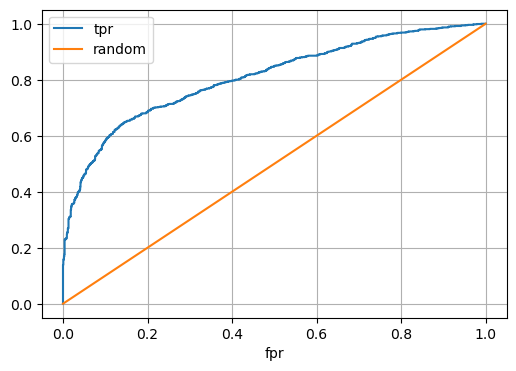

In [40]:
fpr, tpr, thr = roc_curve(y_valid, valid_predictions)
roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thr':thr});
roc['random'] = roc['fpr'].copy()
roc['diff'] = roc['tpr'] - roc['fpr']
roc.plot(x='fpr', y=['tpr','random'], figsize=(6,4), grid=True)

In [41]:
roc = roc.sort_values('diff', ascending=False).reset_index().drop('index', axis=1)

In [42]:
roc

,fpr,tpr,thr,random,diff
0,0.144282,0.647299,0.711686,0.144282,0.503016
1,0.143515,0.646279,0.717899,0.143515,0.502764
2,0.146585,0.649337,0.705278,0.146585,0.502753
3,0.142748,0.645260,0.722109,0.142748,0.502512
4,0.135073,0.637105,0.745521,0.135073,0.502032
...,...,...,...,...,...
788,0.989256,0.998981,0.001438,0.989256,0.009725
789,0.000000,0.009174,1.000000,0.000000,0.009174
790,0.000000,0.007136,1.000000,0.000000,0.007136
791,0.000000,0.000000,2.000000,0.000000,0.000000


In [43]:
roc.loc[0,'thr']

0.7116865